In [1]:
from ProjectTools import OpenBeds
import math

dry = False

def filterDepth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*math.sqrt(average))]
    # df = df.loc[df["readCount"] == 15] # Testing constant readcount
    return df

if dry == True:
    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_3mod_mc, nano_3mod_hmc = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    
    nano_2mod = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))

else:
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_3mod_mc, nano_3mod_hmc = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    
    nano_2mod = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))

In [2]:
import pandas as pd

def filterMods(df):
    return df.loc[df["percentMeth"] == 100]

def filterHemiMods(df): 
    return df.loc[(df["percentMeth"] < 100) & (df["percentMeth"] > 0)]

def filterNoMods(df): 
    return df.loc[df["percentMeth"] == 0]

def nonZeroMod(df):
    return df.loc[df["percentMeth"] > 0]

def filterIntersect(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore"
    df1, df2 = map(filterHemiMods, [df1, df2])
    return pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def noModsAtAll(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore"
    df1, df2 = map(filterNoMods, [df1, df2])
    return pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def modUnmodIntersect(present, absent):
    present["method"], absent["method"] = "Nanopore", "Nanopore"
    intersect = filterHemiMods(present)
    exclusion = filterNoMods(absent)
    return  pd.merge(intersect, exclusion, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def modIntersect(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore" 
    hemi_df1, hemi_df2 = filterHemiMods(df1), filterHemiMods(df2), 
    intersect = pd.merge(hemi_df1, hemi_df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    return intersect.loc[intersect[["percentMeth_x", "percentMeth_y"]].sum(axis=1) == 100]

def totalOverlap(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore" 
    hemi_df1, hemi_df2 = filterHemiMods(df1), filterHemiMods(df2), 
    intersect = pd.merge(hemi_df1, hemi_df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    return intersect.loc[intersect[["percentMeth_x", "percentMeth_y"]].sum(axis=1) != 100]

def calculateModRatio(df1, df2):
    merged_df = pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    mod1, mod2 = df1["modification_type"][0], df2["modification_type"][0]
    merged_df["{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] = merged_df["percentMeth_x"].div(merged_df["percentMeth_y"], axis=0)
    merged_df.loc[merged_df["{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] == math.inf, "{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] = 1.0

    return merged_df[["chromosome", "chromStart", "chromEnd", "readCount", "{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2), "strand"]].dropna()


In [3]:
from pybedtools import BedTool

def intersect_genes(ratio_df, gene_path):
    """
    Note: Strand must be located on the same column in both bed files. 
    """
    gene_ref_bed = BedTool(gene_path)
    ratio_bed = BedTool.from_dataframe(ratio_df)

    intersect = ratio_bed.intersect(gene_ref_bed, wb=True, s=True)
    names = ["chromosome", "chromStart", "chromEnd", "readCount",  "ratio", "strand", "dupChrom", "thickStart", "thickEnd", "gene_name", "Foo", "dupStrand"]
    redundant_cols = ["dupChrom", "thickStart", "thickEnd", "Foo", "dupStrand"]
    return intersect.to_dataframe(names=names).drop(columns=redundant_cols)

In [4]:
gene_intersect_df = intersect_genes(calculateModRatio(nano_3mod_hmc, nano_3mod_mc), './feature_references/fig5_features/mm39_RefSeqC_select_merged_modified.bed')
genes_df = pd.DataFrame(gene_intersect_df.groupby(by=["gene_name"])["ratio"].mean()).reset_index()
genes_df["CpG_count"] = gene_intersect_df.groupby(by=["gene_name"])["chromStart"].count().to_numpy()

In [5]:
genes_df.sort_values(by="ratio", ascending=False).head(20)

,gene_name,ratio,CpG_count
13602,Mir136,4.125413,1
264,1700039M10Rik,2.861320,6
14009,Mir7223,2.627055,2
8945,Gm17597,2.469471,13
13979,"Mir7046,Rabac1",2.010045,5
6738,Eif1,2.000784,12
9286,Gm30244,2.000000,1
13787,Mir467f,1.912157,3
7201,Fahd1,1.846339,1
12480,LOC115487221,1.824754,19


In [6]:
import upsetplot
from upsetplot import from_memberships

upsetplot_ds = from_memberships(
    [["C"], 
    ["5mC"],
    ["C", "5mC"],
    ["5hmC"],
    ["5mC", "5hmC"],
    ["C", "5hmC"],
    ["C", "5mC", "5hmC"],
    ],
    data = [
        len(noModsAtAll(nano_3mod_mc, nano_3mod_hmc)), 
        len(filterMods(nano_3mod_mc)), 
        len(modUnmodIntersect(nano_3mod_mc, nano_3mod_hmc)), 
        len(filterMods(nano_3mod_hmc)), 
        len(modIntersect(nano_3mod_mc, nano_3mod_hmc)), 
        len(modUnmodIntersect(nano_3mod_hmc, nano_3mod_mc)), 
        len(totalOverlap(nano_3mod_mc, nano_3mod_hmc))
    ]
)
upset = upsetplot.UpSet(upsetplot_ds, show_percentages=True, show_counts="{:.2e}", facecolor="tab:blue", element_size=None, sort_categories_by="-input")


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

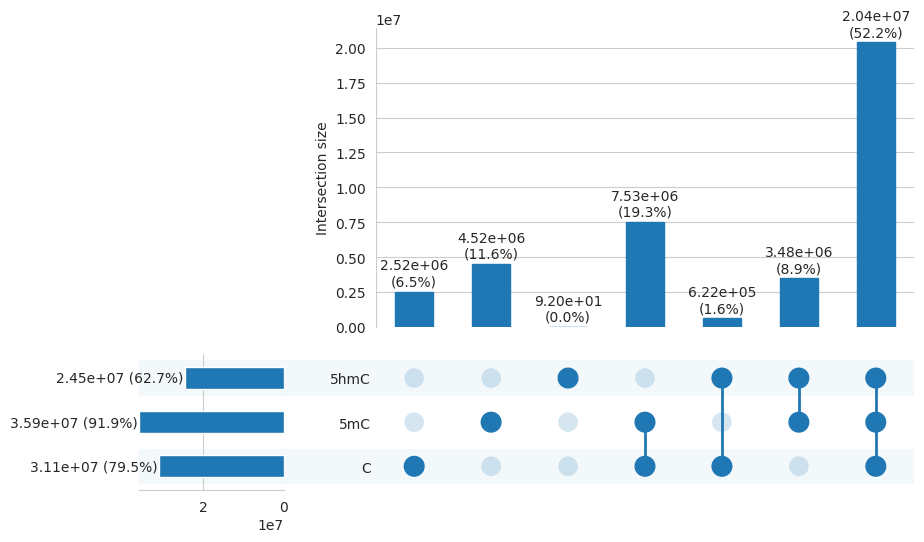

In [10]:
upset.plot()

In [8]:
sns.swarmplot(genes_df, y="ratio", hue="CpG_count", legend="brief")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f55e2bdd360> (for post_execute):


KeyboardInterrupt: 

In [9]:
sns.stripplot(genes_df, y="ratio", hue="CpG_count", legend="brief")

In [7]:
import matplotlib_venn as plv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style("whitegrid")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, fig)

fig1 = fig.add_subfigure(gs[0, :])
upset.plot(fig1)
fig1.suptitle("A")
fig1.supxlabel("CpG modification")

fig2 = fig.add_subfigure(gs[1, 0])
ax2 = fig2.add_subplot()

sns.swarmplot(genes_df, y="ratio", hue="CpG_count", legend="brief", ax=ax2, palette=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
ax2.set_title("B", loc="left")
ax2.set_ylabel("Ratio 5hmC/5mC")
sns.move_legend(ax2, "upper right", title="# CpGs\nin gene")

fig.show()

/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 78.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Error in callback <function flush_figures at 0x7f55e2bdd360> (for post_execute):


KeyboardInterrupt: 

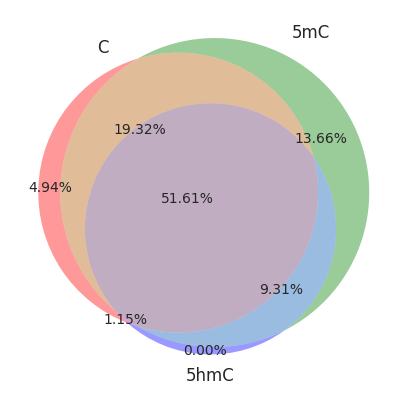

In [ ]:
import matplotlib_venn as plv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, fig)

ax1 = fig.add_subplot(gs[0,:])
venn = plv.venn3(subsets=(len(noModsAtAll(nano_3mod_mc, nano_3mod_hmc)), 
                        len(filterMods(nano_3mod_mc)),
                        len(modUnmodIntersect(nano_3mod_mc, nano_3mod_hmc)),
                        len(filterMods(nano_3mod_hmc)),
                        len(modUnmodIntersect(nano_3mod_hmc, nano_3mod_mc)),
                        len(modIntersect(nano_3mod_mc, nano_3mod_hmc)), 
                        len(totalOverlap(nano_3mod_mc, nano_3mod_hmc))),
                        set_labels=["C", "5mC", "5hmC"],
                        ax=ax1)

total = len(pd.merge(nano_3mod_hmc, nano_3mod_mc, "inner", ["chromosome", "chromStart", "chromEnd", "method", "readCount"]))
venn.get_label_by_id("100").set_text("{:.2%}".format(len(noModsAtAll(nano_3mod_mc, nano_3mod_hmc))/total))
venn.get_label_by_id("010").set_text("{:.2%}".format(len(filterMods(nano_3mod_mc))/total))
venn.get_label_by_id("001").set_text("{:.2%}".format(len(filterMods(nano_3mod_hmc))/total))
venn.get_label_by_id("110").set_text("{:.2%}".format(len(modUnmodIntersect(nano_3mod_mc, nano_3mod_hmc))/total))
venn.get_label_by_id("101").set_text("{:.2%}".format(len(modUnmodIntersect(nano_3mod_hmc, nano_3mod_mc))/total))
venn.get_label_by_id("011").set_text("{:.2%}".format(len(modIntersect(nano_3mod_mc, nano_3mod_hmc))/total))
venn.get_label_by_id("111").set_text("{:.2%}".format(len(totalOverlap(nano_3mod_mc, nano_3mod_hmc))/total))

